In [19]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv src/.env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
import os
os.chdir('/Users/kushagrasharma/coding/hormozlab/src')

from tabulate import tabulate
import numpy as np
from numpy import linalg
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import torchvision

from tqdm import tqdm

from src.AutoEncoder import AE, Encoder, Decoder
from src.Binary2LatentNN import Binary2LatentNN
from src.Binary2TranscriptomeNN import Binary2TranscriptomeNN
from src.utils import *

import seaborn as sns
%matplotlib inline

In [20]:
DATA_DIR = os.environ.get("DATA_DIR")
MODELS_DIR = os.environ.get("MODELS_DIR")
FIG_DIR = os.environ.get("FIG_DIR")

binary_matrix_filepath = MODELS_DIR + 'binary_matrix.npy'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
### Loading Data
binary_matrix = torch.tensor(np.load(binary_matrix_filepath)).float()

train_full = pd.read_csv(DATA_DIR + 'scvi_train_set_gapdh.csv', header=None).to_numpy()
test_full = pd.read_csv(DATA_DIR + 'scvi_test_set_gapdh.csv', header=None).to_numpy()
valid_full = pd.read_csv(DATA_DIR + 'scvi_valid_set_gapdh.csv', header=None).to_numpy()

train_umap = pd.read_csv(DATA_DIR + 'train_coords.csv', header=None).to_numpy()
test_umap = pd.read_csv(DATA_DIR + 'test_coords.csv', header=None).to_numpy()
valid_umap = pd.read_csv(DATA_DIR + 'valid_coords.csv', header=None).to_numpy()

train_tensor = torch.tensor(train_full).float()
valid_tensor = torch.tensor(valid_full).float()
test_tensor = torch.tensor(test_full).float()

train_binary_tensor = torch.matmul(train_tensor, binary_matrix)
valid_binary_tensor = torch.matmul(valid_tensor, binary_matrix)
test_binary_tensor = torch.matmul(test_tensor, binary_matrix)

gaussian_train = np.load(DATA_DIR + 'gaussian_train.npy')
gaussian_valid = np.load(DATA_DIR + 'gaussian_valid.npy')
gaussian_test = np.load(DATA_DIR + 'gaussian_test.npy')

graph = np.load(DATA_DIR + "adjacency_15NN.npy")

N_train_cells = len(graph)
N_valid_cells = len(valid_tensor)
N_test_cells = len(test_tensor)

### Get Laplacian
laplacian_all = np.load(DATA_DIR + 'laplacian_matrix.npy')

### Compute eigen
v_all = np.load(DATA_DIR + 'laplacian_eigenvectors.npy')

In [5]:
## Error metrics
fn_on_matrix = lambda fn: lambda Y, Yhat: np.array([fn(Y[i,:], Yhat[i,:]) for i in range(len(Y))])
wassersteinOnMatrix = fn_on_matrix(wasserstein_distance)
jsOnMatrix = fn_on_matrix(jensenshannon)

errorMetricOnMatrix = jsOnMatrix
errorMetric = lambda Y, Yh: errorMetricOnMatrix(Y, Yh).mean()

We want to understand how effective the Laplacian formulation is at allowing for a reconstruction of the Gaussian distribution. We also want to get a sense for how the Laplacian reconstruction functions. 

We first address the first question by plotting a few Laplacian eigenvectors on the UMAP of the training cells. The eigenvectors are bases for functions on the graph, and by plotting them we can get a sense for how the reconstruction is functioning.

In [6]:
laplacian_projection = np.load(DATA_DIR + "valid_laplacian_projection.npy")

In [7]:
N_coefficients = list(range(1, 100, 10)) + list(range(100, 3952, 100))

In [8]:
def laplacian_reconstruction_n_coeffs(coeffs, n, v_all, norm_fn=lambda x: x ** 2):
    return np.apply_along_axis(
        lambda coeffs: laplacian_coefficients_to_probability(coeffs, v_all, norm_fn), 1, coeffs[:,:n])

In [17]:
v_all.shape

(3595, 3595)

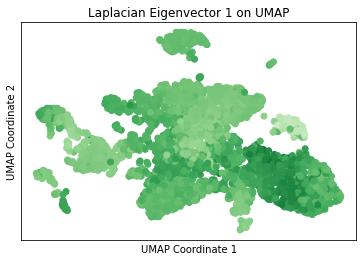

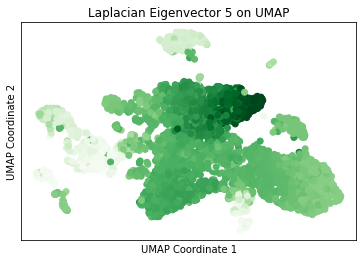

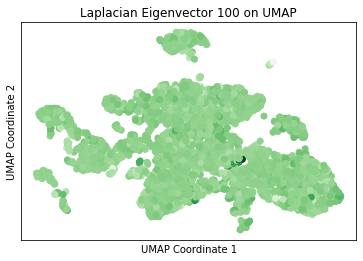

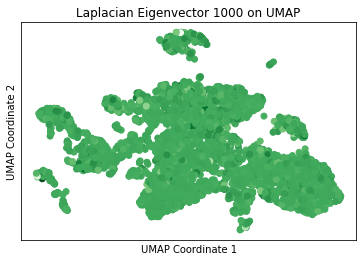

In [23]:
coeffs_to_plot = [0, 4, 99, 999]
for i in coeffs_to_plot:
    plt.scatter(train_umap[:,0], train_umap[:,1], c=v_all[:,i], cmap='Greens')
    plt.title(r'Laplacian Eigenvector {} on UMAP'.format(i+1))
    plt.xlabel("UMAP Coordinate 1")
    plt.ylabel("UMAP Coordinate 2")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(FIG_DIR + 'laplacian_eigenvector{}_umap.png'.format(i+1))
    plt.show()

Next, we examine the effectiveness of the Laplacian reconstruction and the number of coefficients needed to effectively reconstruct a distribution. To probe into this, we first look at the mean JS Divergence when using different numbers of (true) Laplacian coefficients to reconstruct a distribution, in the validation set. 

Secondarily, when we perform our reconstruction using Laplacian coefficients, we need to turn our reconstruction into a probability distribution. Since we're not using all the Laplacian coefficients for many reconstructions, the resulting function is not constrained to be a distribution, so we must make entries positive and normalize. There are a few choices of ways we can make entries positive: exponentiating, squaring, and taking the absolute value. We compare the JS Divergence with respect to the number of coefficients used to make the reconstruction for all three of these methods. 

In [9]:
sq_errors = []
abs_errors = []
exp_errors = []
for n_coeff in N_coefficients:
    laplacian_reconstruction_sq = laplacian_reconstruction_n_coeffs(laplacian_projection, n_coeff, v_all)
    laplacian_reconstruction_abs = laplacian_reconstruction_n_coeffs(laplacian_projection, n_coeff, v_all, np.abs)
    laplacian_reconstruction_exp = laplacian_reconstruction_n_coeffs(laplacian_projection, n_coeff, v_all, np.exp)
    
    sq_errors.append(errorMetricOnMatrix(laplacian_reconstruction_sq, gaussian_valid))
    abs_errors.append(errorMetricOnMatrix(laplacian_reconstruction_abs, gaussian_valid))
    exp_errors.append(errorMetricOnMatrix(laplacian_reconstruction_exp, gaussian_valid))
    
sq_errors = np.array(sq_errors)
abs_errors = np.array(abs_errors)
exp_errors = np.array(exp_errors)

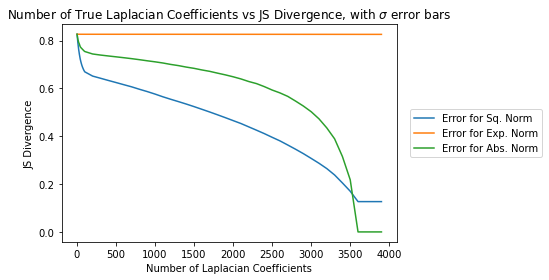

In [10]:
plt.plot(N_coefficients, sq_errors.mean(axis=1), label='Error for Sq. Norm')
plt.plot(N_coefficients, exp_errors.mean(axis=1), label='Error for Exp. Norm')
plt.plot(N_coefficients, abs_errors.mean(axis=1), label='Error for Abs. Norm')
plt.title("Number of True Laplacian Coefficients vs JS Divergence, with $\sigma$ error bars")
plt.ylabel("JS Divergence")
plt.xlabel("Number of Laplacian Coefficients")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

We see from this that the absolute norm becomes better than the squared norm for a very large number of coefficients. This makes sense, because the problem of having negative entries in the reconstructed distribution would no longer be a problem for large numbers of coefficients, because the reconstruction would be naturally a probability distribution without any post-processing. However, for the numbers of coefficients that we use in our reconstructions, the squared method is better, so we proceed with that. 

In [11]:
pd.DataFrame(sq_errors.mean(axis=1), index=N_coefficients)

,0
1,0.826338
11,0.791391
21,0.763607
31,0.741582
41,0.723289
51,0.709428
61,0.697817
71,0.688506
81,0.680710
91,0.673981


We now want to see what the validation accuracy of our neural network Laplacian reconstruction method is when we vary the number of Laplacian coefficients we train to reconstruct. 

In [12]:
toGraph = lambda X: np.apply_along_axis(lambda y: laplacian_coefficients_to_probability(y, v_all), 1, X)

In [13]:
N_coeffs_train = [1, 10, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
                  250, 500, 1000, 2000, 3000, 3200, 3595]
N_coeffs_errors = []
# Using a neural network to reconstruct the first 100 Laplacian eigenvalues
# Then using the Laplacian eigenfunctions to reconstruct the distribution
with torch.no_grad():
    for n_coeff in N_coeffs_train:
        b2L = torch.load(MODELS_DIR + 'binaryToLaplacian{}Coeffs.pt'.format(n_coeff)).eval()
        transf = [b2L, toGraph]

        _, e = transform_and_compute_error(valid_binary_tensor, gaussian_valid, 
                                                transf, errorMetric)

        N_coeffs_errors.append(e)

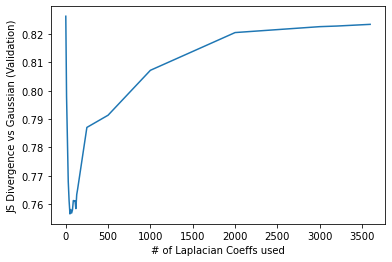

In [14]:
plt.plot(N_coeffs_train, N_coeffs_errors)
plt.xlabel("# of Laplacian Coeffs used")
plt.ylabel("JS Divergence vs Gaussian (Validation)")

plt.show()

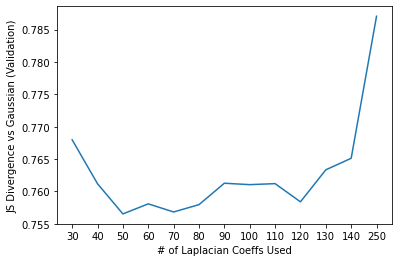

In [15]:
plt.plot([str(x) for x in N_coeffs_train[2:15]], N_coeffs_errors[2:15])
plt.xlabel("# of Laplacian Coeffs Used")
plt.ylabel("JS Divergence vs Gaussian (Validation)")

plt.show()

We see a minimum at $N=50$ coefficients used, so we choose to use that for our reconstruction. 